# UMAP supplementary figure

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

import umap

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7
    
sns_styleset()

In [2]:
def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

X.shape: (15500, 50)
KNN: 0.02, KNC: 0.27, CPD: 0.30
KNN: 0.02, KNC: 0.47, CPD: 0.71


<IPython.core.display.Javascript object>


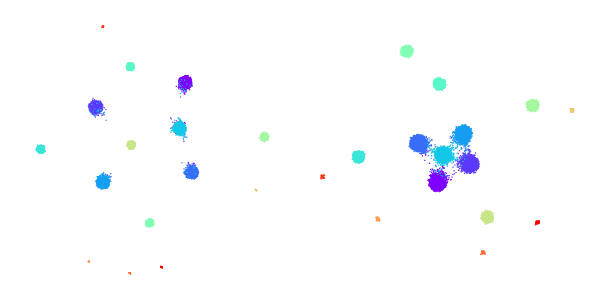

In [3]:
# Toy example

nn = [2000, 2000, 2000, 2000, 2000,  1000, 1000, 1000, 1000, 1000,  100, 100, 100, 100, 100]
d1 = [4,   4,   4,   4,   4,    10,  10,  10,  10,  10,   10,  10,  10,  10,  10]
d2 = [20,  20,  20,  20,  20,   20,  20,  20,  20,  20,   20,  20,  20,  20,  20]
cl = [0,   0,   0,   0,   0,    1,   1,   1,   1,   1,    2,   2,   2,   2,   2]

p = 50   # dimensionality

np.random.seed(42)
X = []
y = []

for i,n in enumerate(nn):
    Xpart = np.random.randn(n,p)
    Xpart[:, i] += d1[i]
    Xpart[:,20+cl[i]] += d2[i]
    X.append(Xpart)
    
    ypart = np.ones(n) * i
    y.append(ypart)
          
X = np.concatenate(X)
y = np.concatenate(y)
print('X.shape:', X.shape)
    
#############################

Z_toy1 = umap.UMAP(random_state=1).fit_transform(X)
Z_toy2 = umap.UMAP(random_state=1, min_dist=.5, n_neighbors=30).fit_transform(X)

qc_toy1 = embedding_quality(X, Z_toy1, y, knn=10, knn_classes=4, subsetsize=1000)
qc_toy2 = embedding_quality(X, Z_toy2, y, knn=10, knn_classes=4, subsetsize=1000)
print('KNN: {:.2f}, KNC: {:.2f}, CPD: {:.2f}'.format(*qc_toy1))
print('KNN: {:.2f}, KNC: {:.2f}, CPD: {:.2f}'.format(*qc_toy2))

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_toy1[:,0], Z_toy1[:,1], s=1, c=y, cmap='rainbow', rasterized=True, edgecolor='none')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_toy2[:,0], Z_toy2[:,1], s=1, c=y, cmap='rainbow', rasterized=True, edgecolor='none')
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

(23822, 45768)
Chosen offset: 6.56
KNN: 0.25, KNC: 0.40, CPD: 0.16
KNN: 0.21, KNC: 0.62, CPD: 0.28


<IPython.core.display.Javascript object>


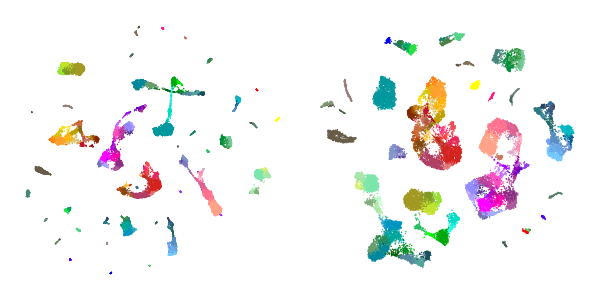

In [6]:
# Tasic data

tasic2018 = pickle.load(open('../data/tasic-nature/tasic2018.pickle', 'rb'))
print(tasic2018['counts'].shape)

import rnaseqTools
importantGenes = rnaseqTools.geneSelection(tasic2018['counts'], n=3000, threshold=32, plot=False)

librarySizes = np.sum(tasic2018['counts'], axis=1)
X = np.log2(tasic2018['counts'][:, importantGenes] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

#############################

Z_tasic1 = umap.UMAP(random_state=1).fit_transform(X)
Z_tasic2 = umap.UMAP(random_state=1, min_dist=.5, n_neighbors=30).fit_transform(X)

qc_tasic1 = embedding_quality(X, Z_tasic1, tasic2018['clusters'], knn=10, knn_classes=10, subsetsize=1000)
qc_tasic2 = embedding_quality(X, Z_tasic2, tasic2018['clusters'], knn=10, knn_classes=10, subsetsize=1000)
print('KNN: {:.2f}, KNC: {:.2f}, CPD: {:.2f}'.format(*qc_tasic1))
print('KNN: {:.2f}, KNC: {:.2f}, CPD: {:.2f}'.format(*qc_tasic2))

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_tasic1[:,0], Z_tasic1[:,1], s=1, rasterized=True,
            c=tasic2018['clusterColors'][tasic2018['clusters']], edgecolor='none')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_tasic2[:,0], Z_tasic2[:,1], s=1, rasterized=True,
            c=tasic2018['clusterColors'][tasic2018['clusters']], edgecolor='none')
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


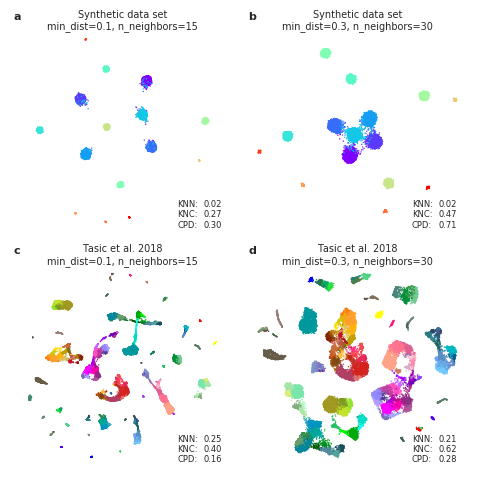

In [7]:
# Compose the figure

plt.figure(figsize=(4.8, 4.8))

plt.subplot(221)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_toy1[:,0], Z_toy1[:,1], s=1, c=y, cmap='rainbow', rasterized=True, edgecolor='none')
plt.text(0.75,.02,'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}\n{:.2f}'.format(*qc_toy1), transform=plt.gca().transAxes, fontsize=6)
plt.xticks([])
plt.yticks([])
plt.title('Synthetic data set\nmin_dist=0.1, n_neighbors=15', va='center')
plt.text(0, 1.05, 'a', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

plt.subplot(222)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_toy2[:,0], Z_toy2[:,1], s=1, c=y, cmap='rainbow', rasterized=True, edgecolor='none')
plt.text(0.75,.02,'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}\n{:.2f}'.format(*qc_toy2), transform=plt.gca().transAxes, fontsize=6)
plt.xticks([])
plt.yticks([])
plt.title('Synthetic data set\nmin_dist=0.3, n_neighbors=30', va='center')
plt.text(0, 1.05, 'b', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

plt.subplot(223)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_tasic1[:,0], Z_tasic1[:,1], s=1, rasterized=True,
            c=tasic2018['clusterColors'][tasic2018['clusters']], edgecolor='none')
plt.text(0.75,.02,'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}\n{:.2f}'.format(*qc_tasic1), transform=plt.gca().transAxes, fontsize=6)
plt.xticks([])
plt.yticks([])
plt.title('Tasic et al. 2018\nmin_dist=0.1, n_neighbors=15', va='center')
plt.text(0, 1.05, 'c', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

plt.subplot(224)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_tasic2[:,0], Z_tasic2[:,1], s=1, rasterized=True,
            c=tasic2018['clusterColors'][tasic2018['clusters']], edgecolor='none')
plt.text(0.75,.02,'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}\n{:.2f}'.format(*qc_tasic2), transform=plt.gca().transAxes, fontsize=6)
plt.xticks([])
plt.yticks([])
plt.title('Tasic et al. 2018\nmin_dist=0.3, n_neighbors=30', va='center')
plt.text(0, 1.05, 'd', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('figures/umap-small.png', dpi=150)
plt.savefig('figures/umap-small.pdf', dpi=300)
plt.savefig('figures/umap-small-600.pdf', dpi=600)

## Large data sets

<IPython.core.display.Javascript object>


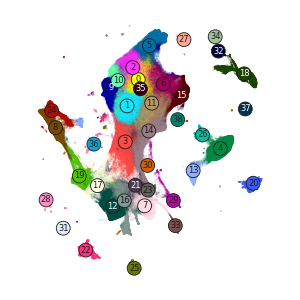

In [9]:
# 1.3 mln data set

clusterCols = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"][:60]
clusterCols = np.array(clusterCols)

Zs, clustersScanpy = pickle.load(open("big-pickles/10x-tsne.pickle", "rb"))
Z_mln = Zs['umap']
    
plt.figure(figsize=(3,3))
plt.gca().set_aspect('equal', adjustable='datalim')

np.random.seed(42)
ind = np.random.permutation(Z_mln.shape[0])
plt.scatter(Z_mln[:,0][ind], Z_mln[:,1][ind], s=1, c=clusterCols[clustersScanpy][ind], 
            alpha=.1, rasterized=True, edgecolor='none')
    
K = np.max(clustersScanpy)+1
Zmeans = np.zeros((K, 2))
for c in range(K):
    Zmeans[c,:] = np.median(Z_mln[clustersScanpy==c,:2], axis=0)
          
plt.scatter(Zmeans[:,0], Zmeans[:,1], color=clusterCols[:K], s=100, edgecolor='k', linewidth=.6)
for c in range(K):
    if c in [12,21,37,32,35,9,15,18]:
        col = 'w'
    else:
        col = 'k'
    plt.text(Zmeans[c,0], Zmeans[c,1], str(c), fontsize=6, 
             color=col, ha='center', va='center')

plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


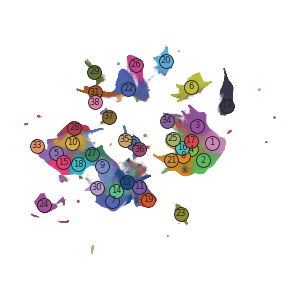

In [10]:
# Cao et al

clusterColors = np.array('''#c886ba #5cbb5e #9751a0 #84b941 #8e6db0 #bbbb3c #5667b0 #e58824 #778cc6 #d6ac3d
#785aa5 #204a87 #36384a #5ec08d #e53e77 #50c1b4 #dd464a #3bbbc6 #d6552c #5baada #cf8a34 #4d62ad
#8b8a34 #a34f9a #9db36b #cb4188 #37825c #b23d4f #5d7131 #b59ac9 #a55725 #5277af #e38f68 #86619d
#caa56a #9c476d #886a2c #dd81a9'''.split())

Z_cao, clusters, clusterNames = pickle.load(open('big-pickles/cao-tsne.pickle', 'rb'))
Z_cao = Zs['umap']

np.random.seed(42)
ind = np.random.permutation(np.sum(clusters>=0))
plt.figure(figsize=(3,3))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_cao[clusters>=0,0][ind], Z_cao[clusters>=0,1][ind], s=1,
            c=clusterColors[clusters][clusters>=0][ind], 
            edgecolor='none', alpha=.1, rasterized=True)
for cl in range(38):
    mu = np.median(Z_cao[clusters==cl,:], axis=0)
    plt.scatter(mu[0], mu[1], c=clusterColors[cl], s=100, edgecolor='k', linewidth=.6)
    plt.text(mu[0], mu[1], cl+1, fontsize=6, ha='center', va='center')

plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [13]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn_classes=10, subsetsize=1000, seed=42):
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    np.random.seed(seed)
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn_global, rho)

ind4metric = clusters>=0
X = pickle.load(open('big-pickles/cao-pca.pickle', 'rb'))
metrics_cao = embedding_quality(X[ind4metric,:], Z_cao[ind4metric,:], clusters[ind4metric])

X = pickle.load(open('big-pickles/10x-pca.pickle', 'rb')).astype(float)
metrics_mln = embedding_quality(X, Z_mln, clustersScanpy)

<IPython.core.display.Javascript object>


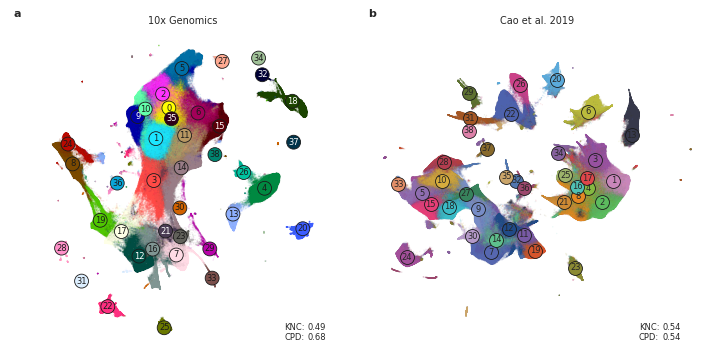

In [14]:
plt.figure(figsize=(7.2, 3.6))

plt.subplot(121)
plt.gca().set_aspect('equal', adjustable='datalim')
np.random.seed(42)
ind = np.random.permutation(Z_mln.shape[0])
plt.scatter(Z_mln[:,0][ind], Z_mln[:,1][ind], s=1, c=clusterCols[clustersScanpy][ind], 
            alpha=.1, rasterized=True, edgecolor='none')
    
K = np.max(clustersScanpy)+1
Zmeans = np.zeros((K, 2))
for c in range(K):
    Zmeans[c,:] = np.median(Z_mln[clustersScanpy==c,:2], axis=0)
          
plt.scatter(Zmeans[:,0], Zmeans[:,1], color=clusterCols[:K], s=100, edgecolor='k', linewidth=.6)
for c in range(K):
    if c in [12,21,37,32,35,9,15,18]:
        col = 'w'
    else:
        col = 'k'
    plt.text(Zmeans[c,0], Zmeans[c,1], str(c), fontsize=6, 
             color=col, ha='center', va='center')
plt.xticks([])
plt.yticks([])
plt.title('10x Genomics')
plt.text(0, 1.05, 'a', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
plt.text(0.8,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}'.format(*metrics_mln), transform=plt.gca().transAxes, fontsize=6)

plt.subplot(122)
plt.gca().set_aspect('equal', adjustable='datalim')
np.random.seed(42)
ind = np.random.permutation(np.sum(clusters>=0))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_cao[clusters>=0,0][ind], Z_cao[clusters>=0,1][ind], s=1,
            c=clusterColors[clusters][clusters>=0][ind], 
            edgecolor='none', alpha=.1, rasterized=True)
for cl in range(38):
    mu = np.median(Z_cao[clusters==cl,:], axis=0)
    plt.scatter(mu[0], mu[1], c=clusterColors[cl], s=100, edgecolor='k', linewidth=.6)
    plt.text(mu[0], mu[1], cl+1, fontsize=6, ha='center', va='center')
plt.xticks([])
plt.yticks([])
plt.title('Cao et al. 2019')
plt.text(0, 1.05, 'b', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
plt.text(0.8,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}'.format(*metrics_cao), transform=plt.gca().transAxes, fontsize=6)

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('figures/umap-big.png', dpi=150)
plt.savefig('figures/umap-big.pdf', dpi=300)
plt.savefig('figures/umap-big-600.pdf', dpi=600)